# Hydraulic Fracturing Optimization: Predicting Well Production

## Abstract
Oil and gas well operators have a lot of decisions to make in regards to drilling, completing, and hydraulic fracturing the well, all to maximize the production of the well. Most of these decisions are made in silos, as competition restricts the sharing of information. The aim of this project is to determine what the optimal conditions for these wells are to help guide this decision making process, looking specifically at well drilling characteristics and the hydraulic fracturing fluid systems used.

For this project, I used linear regression, random forest regression, random forest quantile regression, and gradient boosting regression. Overall, the models that explained the most variance in the data was the random forest quantile regression model, and the random forest regression model. These models had R-squared values of 0.5722 (+/- 0.14) and 0.5703 (+/-0.14), respectfully. The gradient boosting regression model was not far behind with an R-squared value of 0.5588 (+/- 0.16), however the linear regression model explained the least amount of variance in the model with an R-squared score of 0.3367 (+/- 0.19). The Random forest models were both able to paint a picture of the importances of different well and frac features, notably that the slickwater fluid system has the greatest odds of increasing production, followed by the cross-linked gel fluid system. The well features that had the greatest odds of increasing production were a vertical depth of around 6600 ft, a horizontal length of about 2 miles, and using over 600 pounds of sand per foot of well drilled. Well operators can use this information to optimize the production of their wells and minimize the impact of ineffective fluid systems.


## Business Problem
### Introduction
While hotly debated, hydraulic fracturing is used after the drilling of an oil or gas well is complete. Hydraulic fracturing uses fluid and other materials to create small fractures in a rock formation in order to stimulate the production of oil and gas from the well. While water and sand are the major components of this fluid, each individual well operator has control over what else is added to this fluid. There are many different schools of thought behind the use of individual additional ingredients without much evidence to support the use of one method over another. Fortunately well operators are required to keep detailed records of the ingredients used, including the amount of such ingredients. Here I will investigate the three  main fluid systems used in fracing a well: adding slickwater friction reducers, using gelling agents, and also cross-linking the gelling agents.  Comparing the fluid systems used to the resulting production from each well can help well operators make better decisions regarding the most effective fluid system to use when fracing their wells.

### Research Questions
What well characteristics and frac fluid systems are determinant for higher production of the well?

### Data
The well production data I used was from a proprietary software provided by [DrillingInfo](Drillinginfo.com).  The overall Colorado data alone has 15K wells, and 99 columns, including all types of wells, not just horizontal wells, which will be the focus of this analysis. The frac ingredients and therefore fluid systems used are from the [FracFocus Chemical Registry](fracfocus.org).  This data set is for the entire country and contains 3.2M entries, with numerous entries per well, and 39 columns. Both of these data sources were provided by an industry professional and the files are uploaded to [Google Drive](https://drive.google.com/drive/u/0/folders/1XvwIHSMJVQs7U-nzpQhcedv4LWQ8Ta7J) as their sizes are prohibitive of uploading to Github. 

#### Note: 
This is a summary notebook, further detail on data cleaning for [Colroado](https://github.com/ephs08kmp/Frac_Production/blob/master/Frac_Production_Data_Cleaning.ipynb), [Montana](https://github.com/ephs08kmp/Frac_Production/blob/master/MT_Frac_Production_Cleaning.ipynb), [Oklahoma and Texas](https://github.com/ephs08kmp/Frac_Production/blob/master/OK_Frac_Production_Cleaning.ipynb); [exploratory data analysis](https://github.com/ephs08kmp/Frac_Production/blob/master/Frac_Production_Analysis.ipynb); modeling for [Colorado](https://github.com/ephs08kmp/Frac_Production/blob/master/Frac_Production_Modeling_CO.ipynb), and an extension on the transference of this analysis [across states](https://github.com/ephs08kmp/Frac_Production/blob/master/Frac_Production_Modeling_Multi_States.ipynb) are all linked.

## Imports

In [1]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Setting Preferences
sns.set(style='white', color_codes=True)
plt.rcParams.update({'font.size': 22})

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning
import re

# Statistics
from scipy.stats import pearsonr, spearmanr, linregress
from scipy.stats import shapiro, mannwhitneyu, kruskal

# Feature engineering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Model Imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from skgarden import RandomForestQuantileRegressor

# Interpreting Models
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

## Importing Data
This data is the well information and production data that has previously been cleaned and joined with the FracFocus data.  Further detail can be found [here](https://github.com/ephs08kmp/Frac_Production/blob/master/Frac_Production_Data_Cleaning.ipynb)

In [2]:
# Reading in ALL Colorado Features (pre-feature selection)
cofrac = pd.read_csv('fracwells_co.csv', index_col=0)
cofrac.head()

,WellName,WellNumber,OperatorAlias,Field,TargetFormation,TotalDepth,VerticalDepth,DrillType,UpperPerforation,LowerPerforation,...,FirstProdDate,Township,Range,TR,County,slick,gel,xlinkgel,hybrid,sandmass
APINumber,,,,,,,,,,,,,,,,,,,,,
5001097530000,WEP,4-28-11-3-64,AXIS ENERGY,DJ HORIZONTAL NIOBRARA,NIOBRARA,11431.00,7551.00,H,7519.0,11431.0,...,2017-04-01,03S,64W,03S64W,Adams,0,0,0,0.0,0.000000e+00
5001097540000,WEP,1-28-11-3-64,AXIS ENERGY,DJ HORIZONTAL NIOBRARA,NIOBRARA,11715.00,7594.00,H,8151.0,11715.0,...,2013-02-01,03S,64W,03S64W,Adams,0,0,0,0.0,0.000000e+00
5001098010000,SHARP,24-3-11HC,WARD PETR,WATTENBERG,CODELL,10161.00,7774.00,H,NaN,NaN,...,2015-01-01,01S,67W,01S67W,Adams,1,0,1,1.0,2.533881e+06
5001097850000,STATE OF CO,1S-66-36-1609CH,EXTRACTION O&G,THIRD CREEK,NIOBRARA,12177.31,7576.73,H,NaN,NaN,...,2014-06-01,01S,66W,01S66W,Adams,1,0,1,1.0,3.274332e+06
5001097830000,STATE OF CO,1S-66-36-0108BH,EXTRACTION O&G,THIRD CREEK,NIOBRARA,12164.98,7511.68,H,NaN,NaN,...,2014-06-01,01S,66W,01S66W,Adams,1,0,1,1.0,3.045143e+06


In [3]:
cofrac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5220 entries, 5001097530000 to 5005071970000
Data columns (total 27 columns):
WellName                   5220 non-null object
WellNumber                 5220 non-null object
OperatorAlias              5220 non-null object
Field                      5220 non-null object
TargetFormation            5220 non-null object
TotalDepth                 5212 non-null float64
VerticalDepth              5210 non-null float64
DrillType                  5220 non-null object
UpperPerforation           4319 non-null float64
LowerPerforation           4319 non-null float64
GrossPerforatedInterval    4319 non-null float64
HorizontalLength           5218 non-null float64
TreatmentJobCount          5218 non-null float64
CumBOE                     5220 non-null float64
CumGas                     5220 non-null float64
CumOil                     5220 non-null float64
First6BOE                  5220 non-null float64
FirstProdDate              5220 non-null obje

### Location Normalization
Now, there are a number of different location information points.  In order to reduce the feature space and generalize for all of those features, I will perform clustering to group these data points into similar locations, which should help to account for the different rock formations and locations.  I will cluster based on township/range, county, field, and target formation.

In [4]:
# Pulling out location-based identifiers to cluster
loc = cofrac[['TR','County', 'Field', 'TargetFormation']]
loc = pd.get_dummies(loc)
loc.head()

,TR_01N64W,TR_01N65W,TR_01N66W,TR_01N67W,TR_01N68W,TR_01S66W,TR_01S67W,TR_01S68W,TR_02N63W,TR_02N64W,...,Field_NORTH RIVERSIDE,Field_RIVERSIDE,Field_SEVERANCE,Field_SPINDLE,Field_THIRD CREEK,Field_WATTENBERG,Field_WILDCAT,TargetFormation_CODELL,TargetFormation_NIOBRARA,TargetFormation_OTHER
APINumber,,,,,,,,,,,,,,,,,,,,,
5001097530000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5001097540000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5001098010000,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5001097850000,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5001097830000,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


Great, now I will try different cluster numbers to determine, based on silhouette score, which clusters have the closest commonalities.

In [5]:
# Iterating over numbers of clusters to determine best clustering
for n in range(2,22,2):
    kmeans = KMeans(n_clusters=n, random_state=42).fit(loc)
    labels = kmeans.labels_
    print('Number of Clusters: {}'.format(n))
    print(silhouette_score(loc, labels, metric='euclidean'))

Number of Clusters: 2
0.2631580379477226
Number of Clusters: 4
0.3120062262557086
Number of Clusters: 6
0.22808814232341865
Number of Clusters: 8
0.2597337656879311
Number of Clusters: 10
0.25998048619560443
Number of Clusters: 12
0.3324021490239039
Number of Clusters: 14
0.3796137923286643
Number of Clusters: 16
0.41977717309019313
Number of Clusters: 18
0.42310091073408107
Number of Clusters: 20
0.4426048663327202


I will choose 16 clusters to normalize these clusters.  Although the silhouette score continues to increase after 16 clusters, this is the last large jump of 0.03 in silhouette score.  Now, I will create these labels as locations in our data set, and I will also perform a kruskal test to make sure that there are differences in production between these variables.

In [6]:
kmeans = KMeans(n_clusters=16, random_state=42).fit(loc)
labels = kmeans.labels_
cofrac['location'] = labels
t, p = kruskal(cofrac[cofrac['location']==0]['First6BOE'],
               cofrac[cofrac['location']==1]['First6BOE'], 
               cofrac[cofrac['location']==2]['First6BOE'],
               cofrac[cofrac['location']==3]['First6BOE'],
              cofrac[cofrac['location']==4]['First6BOE'],
              cofrac[cofrac['location']==5]['First6BOE'],
              cofrac[cofrac['location']==6]['First6BOE'],
              cofrac[cofrac['location']==7]['First6BOE'],
              cofrac[cofrac['location']==8]['First6BOE'],
              cofrac[cofrac['location']==9]['First6BOE'],
              cofrac[cofrac['location']==10]['First6BOE'],
              cofrac[cofrac['location']==11]['First6BOE'],
              cofrac[cofrac['location']==12]['First6BOE'],
              cofrac[cofrac['location']==13]['First6BOE'],
              cofrac[cofrac['location']==14]['First6BOE'],
              cofrac[cofrac['location']==15]['First6BOE'])
print(p)

5.666858182759195e-124


Great! These look like they have differences between one another in terms of production. I will check their distributions through graphing to determine if this is visually accurate.

## Exploratory Data Analysis 
Further detail on EDA can be found [here](https://github.com/ephs08kmp/Frac_Production/blob/master/Frac_Production_Analysis.ipynb)
### Production - First 6 Months BOE
First, let's take a look at the distribution of our target variable, the first 6 month's of production in barrels of oil equivalencies (BOE).  This will show us how the prodution is distributed and will tell us how we will need to compare the other distributions in our statistical analyses.

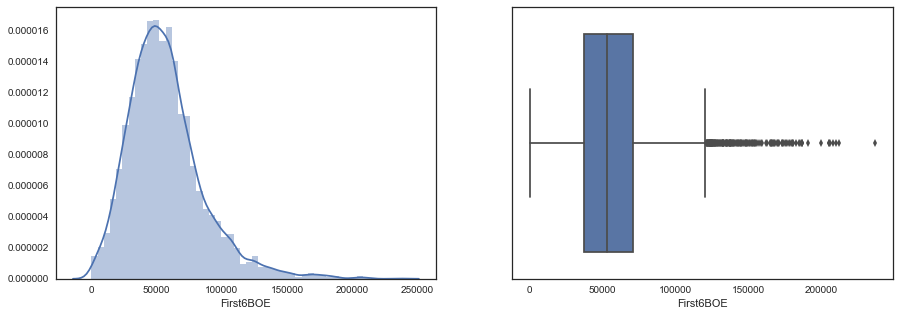

Shapiro-Wilk test for Normality:
W: 0.9342953562736511
p-value:4.091791515828466e-43


In [7]:
# Plotting the distribution of First 6 month's BOE
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(cofrac.First6BOE)
plt.subplot(122)
sns.boxplot(cofrac.First6BOE)
plt.show()

w, p = shapiro(cofrac.First6BOE)
print('Shapiro-Wilk test for Normality:\nW: {}\np-value:{}'.format(w, p))

It appears that the distribution of the first six months of production is skewed to the right with the median just above 50K BOE and a good amount of outliers above 150K BOE.  Also, according to the Shapiro-Wilk test for normality, we can reject that the distribution is approximately normally distributed.  

### Distributions
To investigate whether the columns are correlated with higher production, I will graph both the distribution of the individual column data along with its distribution relative to first 6 month's BOE.

In [8]:
# Isolating columns to examine and removing identifiers
cofrac_red = cofrac[['First6BOE', 'County', 'location', 'Field','GrossPerforatedInterval',
                     'HorizontalLength', 'LowerPerforation','TargetFormation','TotalDepth', 
                     'TreatmentJobCount', 'TR', 'UpperPerforation', 'VerticalDepth',
                    'gel', 'sandmass','slick', 'xlinkgel', 'hybrid']]

County


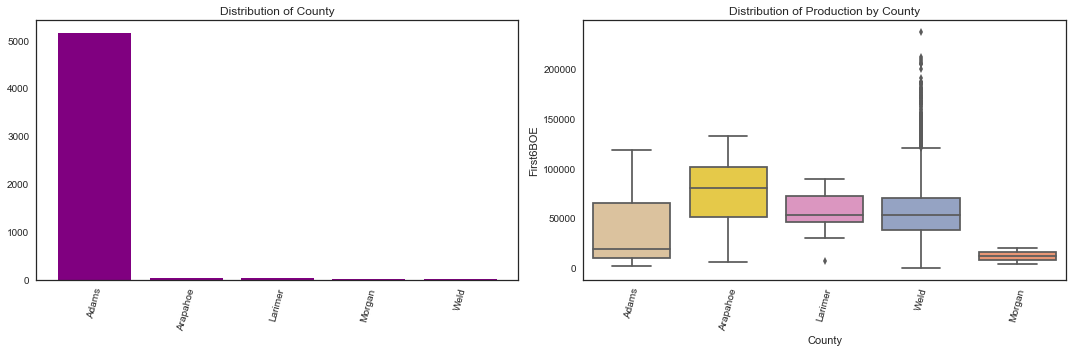

location


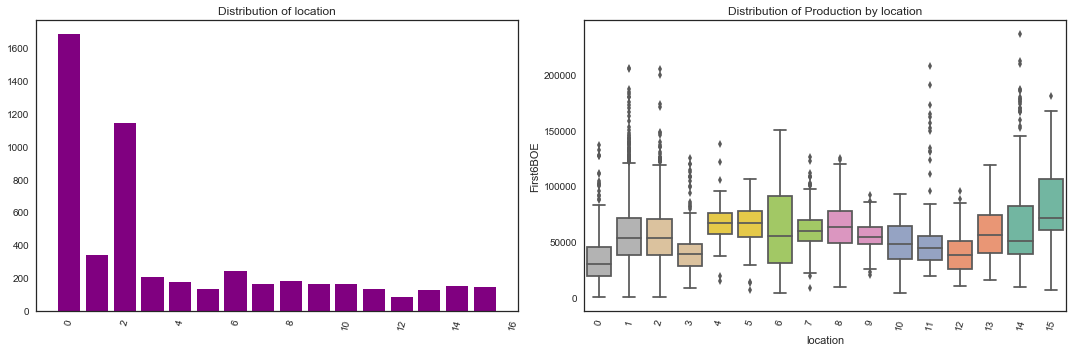

Field


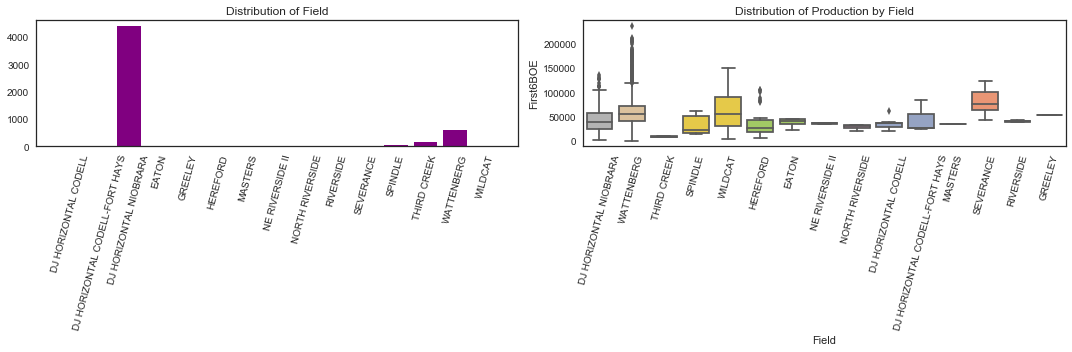

GrossPerforatedInterval


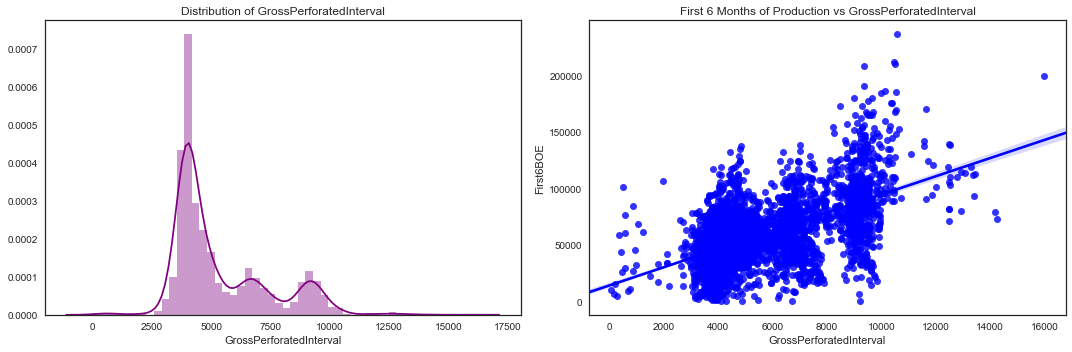

HorizontalLength


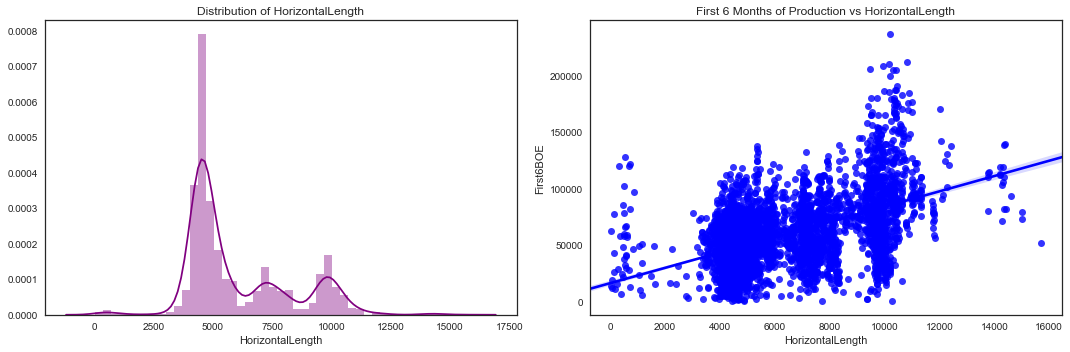

LowerPerforation


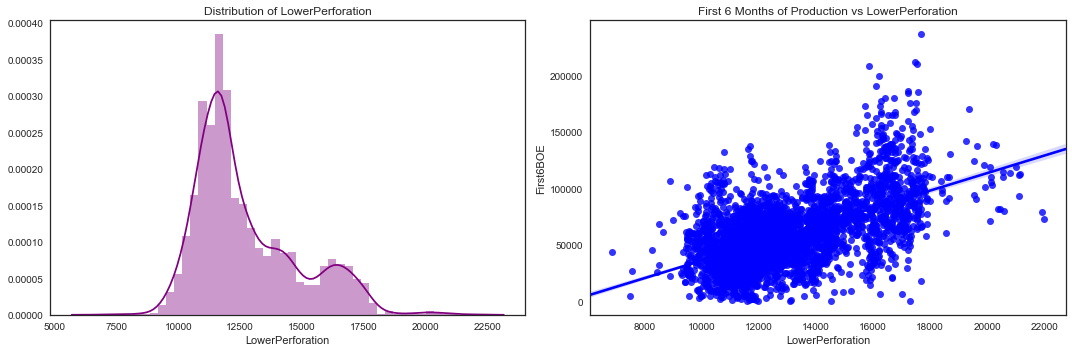

TargetFormation


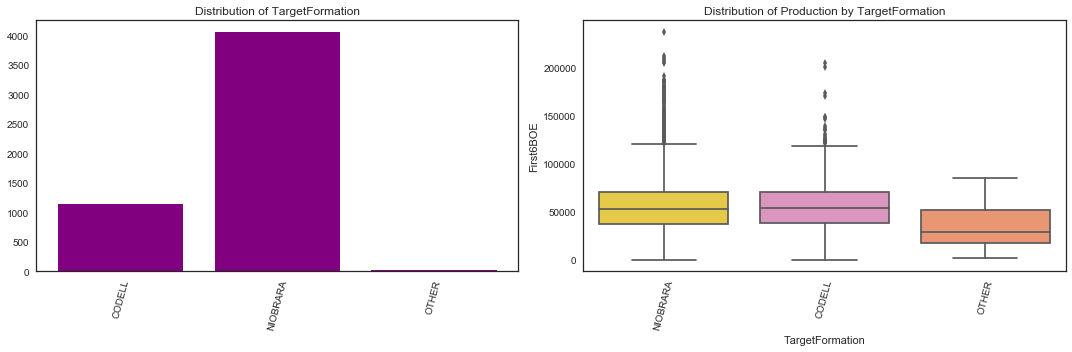

TotalDepth


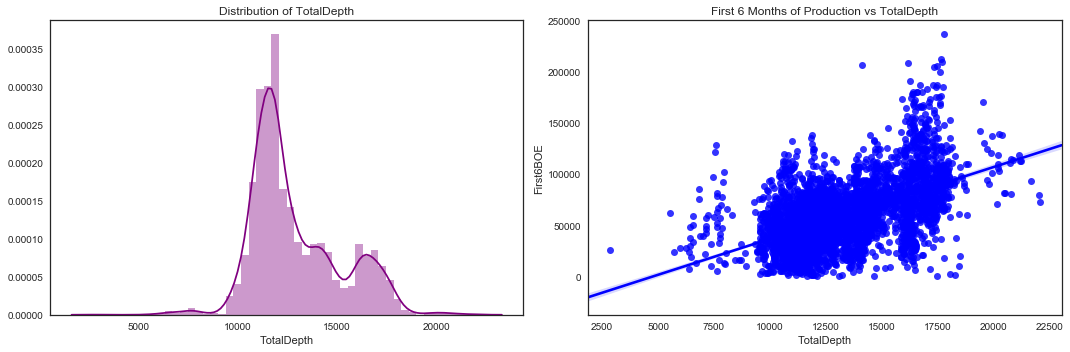

TreatmentJobCount


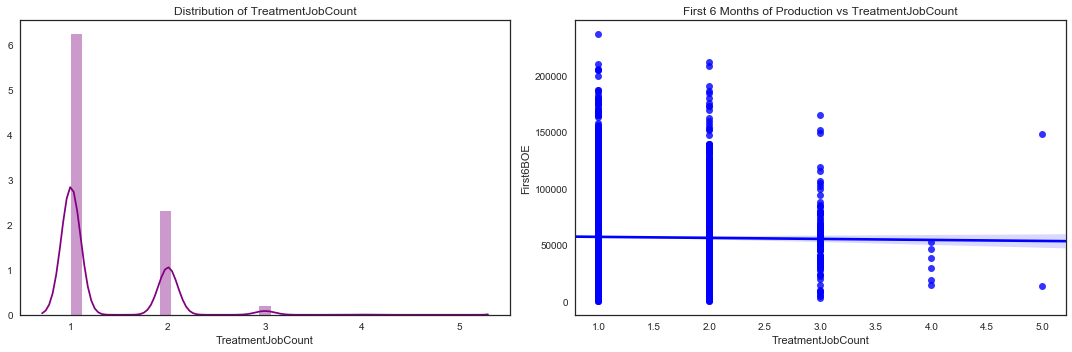

TR


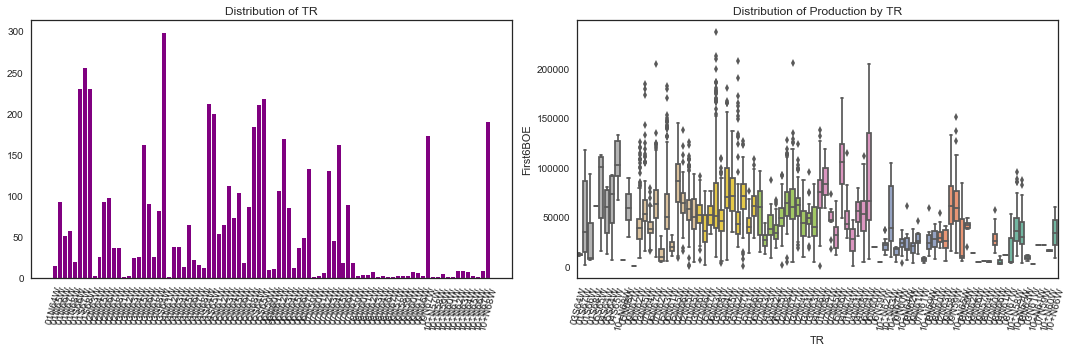

UpperPerforation


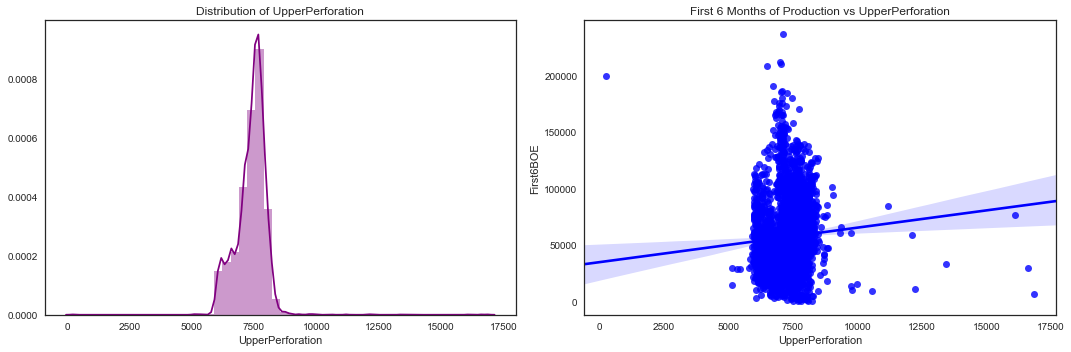

VerticalDepth


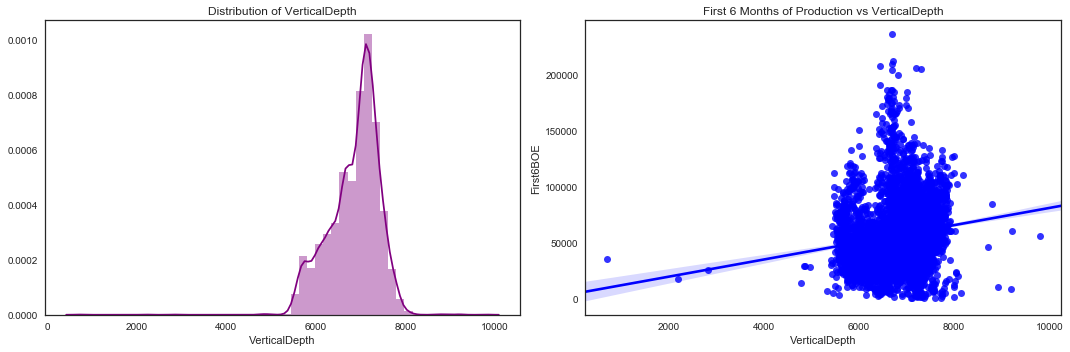

gel


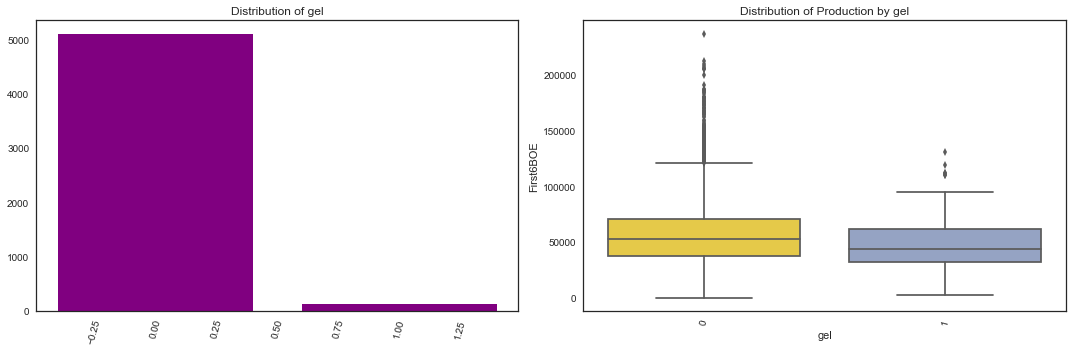

sandmass


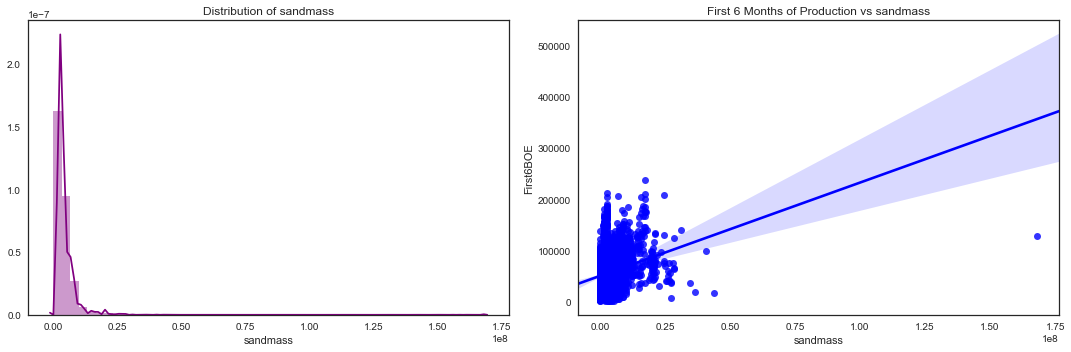

slick


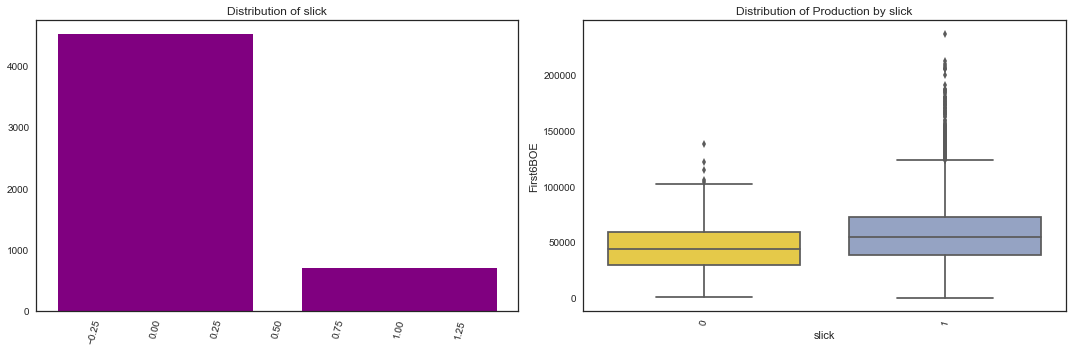

xlinkgel


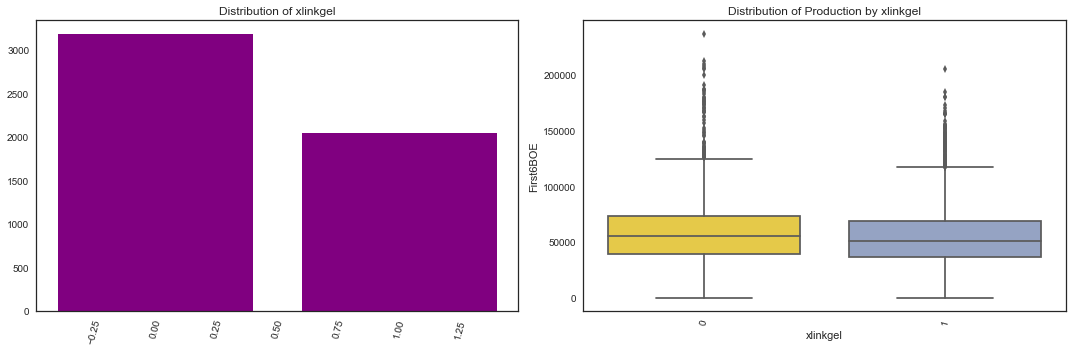

hybrid


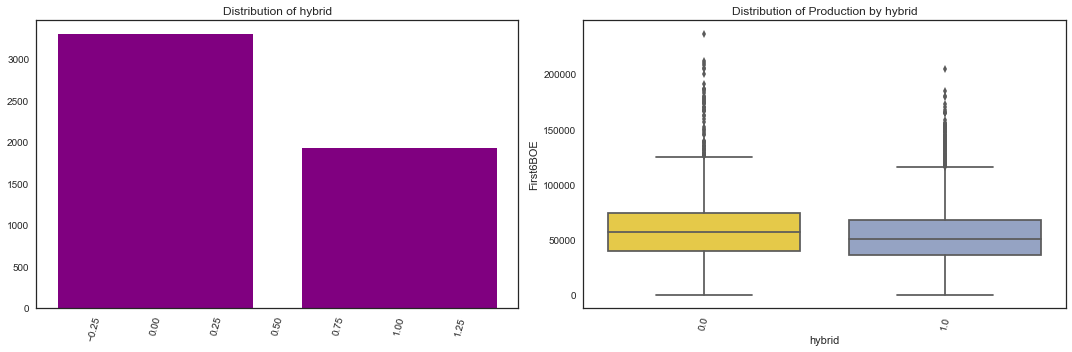

In [9]:
# Creating plots for each column except First 6 BOE
for col in cofrac_red.columns.drop('First6BOE'):
    print(col)
    if col in cofrac_red.select_dtypes(include='object').columns or col in ['gel','slick','xlinkgel','hybrid', 'location', 'County']:
        # Plotting distributions of each column
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        temp = cofrac_red[[col, 'First6BOE']]
        temp = temp.dropna()
        plt.bar(temp[col].unique(), height=temp[col].value_counts(), color='Purple')
        plt.xticks(rotation=75)
        plt.title('Distribution of {}'.format(col))
    
        # Plotting distributions of each column by first 6 months production
        plt.subplot(122)
        g = sns.boxplot(y='First6BOE', x=col, data=temp, palette='Set2_r')
        plt.xticks(rotation=75)
        plt.title('Distribution of Production by {}'.format(col))
    
        plt.tight_layout()
        plt.show()
    elif col in cofrac_red.select_dtypes(include=['int64','float64']).columns.drop(['gel','slick','xlinkgel','hybrid']):
        # Plotting distributions of each column
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        sns.distplot(cofrac_red[col].dropna(axis=0), color='Purple')
        plt.title('Distribution of {}'.format(col))
        
        # Plotting scatter plot of each column by production
        plt.subplot(122)
        #temp = cofrac_red[[col, 'First6BOE']]
        #temp = temp.dropna()
        sns.regplot(x=cofrac_red[col], y=cofrac_red['First6BOE'], color='Blue')
        plt.title('First 6 Months of Production vs {}'.format(col))
        
        plt.tight_layout()
        plt.show()


Insights from these visualizations:
- The __location__ clusters are fairly evenly spread, with spikes in location 0 and location 2, however the distributions of production looks like the clustered locations were able to identify some of the more and less productive areas. The following are the analyses of the variables clustered in the location labels:
    - Most of the wells are located in Adam's county, but Weld county has the highest production levels.  
    - The Wattenberg field looks like it is the most productive
    - Niobrara and Codell formations look equally productive, and all other formations less productive
    - Township and ranges are spread all over the place, with only about 10 township and ranges that have low production. 
    - I will be able to __drop all of the location-based features in lieu of the location cluster labels__
- __Gross perforated interval__ has a trimodal distribution, with peaks between 2500-5000, 5000-8000, and 8000-11000.  While the regplot looks like there is a positive correlation between increased perforation intervals, and production, I think this variable might be better __binned into three groups__.
- __Horizontal length__ also has a trimodal distribution, with peaks between 2500-6000, 6000-9000, and 9000-12000 ft. These are typically 1 mile, 1.5 mile, or 2 mile targets.  I will also __put these lengths into three groups__, accordingly.
- __Lower perforation__ is non-normally distributed, so I will need to __identify some transformations to normalize this variable__, but again, it appears that the deeper the lower perforation, the larger the production.
- __Total depth__ appears it could be a bimodal or trimodal distribution, but this is not as clearly delineated.  I again will need to __identify some transformations to normalize this variable__.  I also might want to consider combining some of the depth variables into one.
- __Treatment job count__ is mostly centered at 1, and doesn't appear to have any correlation to production.  I will check the p-value on this, but I will likely __drop treatment job count__ from the data set.
- __Upper perforation__ looks approximately normally distributed, with a slight hump to the left.  I want to see what the __difference between upper and lower perforations__ would look like against the production.
- __Vertical depth__ also has a slight hump to the left at shallower depths, and the production increases slightly with increased depth.  This could be because of its traversal into better formations too, so that's something to look out for in terms of independence.
- The __linear gel__ fluid system is not used very often, and not using linear gel appears to have a slightly higher distribution of production.  I will need to check the p-value on this distribution.
- __Sand mass__ has a significant outlier at 1.7x10^8 lbs of sand, and the distribution looks like it's slightly skewed to the right even without that.  I will need to normalize this distribution and investigate that large sand use well.
- The __slickwater__ fluid system is used in the majority of frac jobs and the production distribution looks very higher when using slickwater.  Again, I will need to check the p-value.
- The __cross-linked gel__ fluid system is again used more than not, and it appears that not cross-linking could be correlated to higher production.  I will check the p-value.
- Wells that use a __hybrid__ fluid system are slightly less productive than those that do not use a hybrid approach.

Now, I want to determine if the different variables have a significant impact on the first six month's production.  Because the distribution of production is non-parametric, I will use the Mann-Whitney U test for the two-value comparisons, the Krustal-Wallis H-test for the variables with three value comparisons, and then the Spearman rank-order correlation coefficient for continuous variables. If the p-values for each of these tests are less than 0.05, then I can reject the null hypothesis that the variables have the same distribution.

In [10]:
# Initializing data frame for p-values from comparison tests
p_vals = pd.DataFrame(columns=['Attribute', 'p_value'])

allflsys = ['gel','slick','xlinkgel', 'hybrid']

for col in cofrac_red.columns:
    if col in allflsys:
        # Calculate Mann-Whitney U test for two-value comparisons
        t, p = mannwhitneyu(cofrac_red[cofrac_red[col]==0]['First6BOE'], 
                            cofrac_red[cofrac_red[col]==1]['First6BOE'])
    
    elif col == 'TargetFormation':
        # Calculate Kruskal-Wallis H-test for three comparisons
        t, p = kruskal(cofrac_red[cofrac_red[col]=='NIOBRARA']['First6BOE'], 
                       cofrac_red[cofrac_red[col]=='CODELL']['First6BOE'],
                      cofrac_red[cofrac_red[col]=='OTHER']['First6BOE'])
    
    elif col in cofrac.select_dtypes(include=['int64','float64']).columns.drop(['First6BOE','gel','slick','xlinkgel', 'hybrid']):
        # Create temporary data frame to drop null values
        temp = cofrac_red[[col, 'First6BOE']].dropna()
        # Calculate Spearman rank-order correlation coefficient for continuous variables
        rho, p = spearmanr(temp[col], temp['First6BOE'])
    
    # Append the p-values and attributes to a data frame
    p_vals = p_vals.append({'Attribute':col, 'p_value':float(p)}, ignore_index=True)

# Sort and print the p-values 
p_vals.sort_values('p_value')

,Attribute,p_value
8,TotalDepth,0.000000e+00
6,LowerPerforation,4.246528e-290
4,GrossPerforatedInterval,3.309099e-273
5,HorizontalLength,8.519498e-244
14,sandmass,6.388584e-72
12,VerticalDepth,1.265438e-50
0,First6BOE,4.091792e-43
2,location,4.091792e-43
1,County,4.091792e-43
3,Field,4.091792e-43


Based on these comparison tests, I can reject the null hypothesis for all variables except for that of the Township and Range, and the Treatment Job Count, as expected.  The other variables have significant p-values, meaning that we can reject the null hypothesis and state that the variable causes a significant difference between the distributions.

In [11]:
# Dropping location-based features and treatment job count
cofracw = cofrac_red.drop(['TR', 'County', 'Field', 'TargetFormation', 'TreatmentJobCount'], axis=1)

#### Sand Mass and Vertical Depth
Because neither of those variables had very normally distributed values, I will attempt to transform them to become more normally distributed. 

sandmass


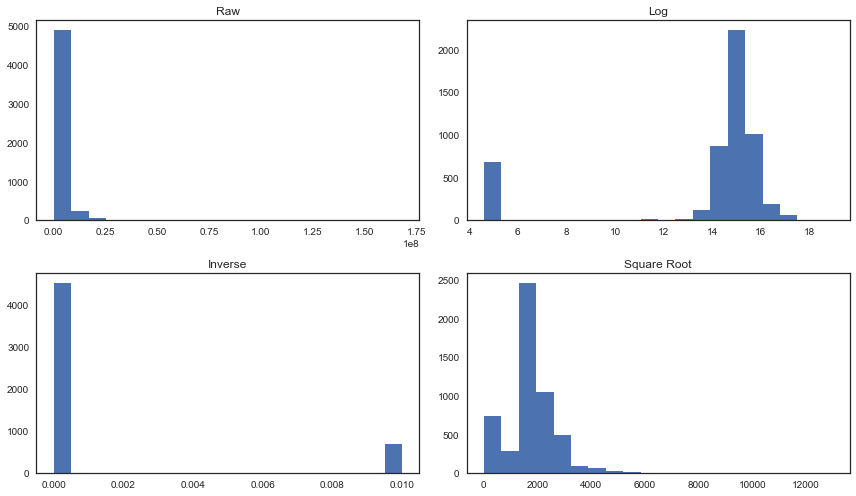

VerticalDepth


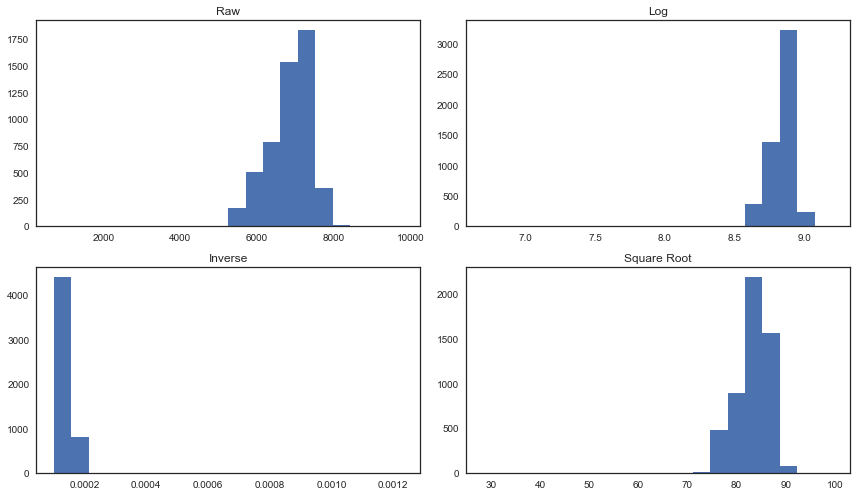

In [12]:
# Transformation to deal with non-normality
for var in ['sandmass','VerticalDepth']:
    print(var)
    plt.figure(figsize=[12,7])
    plt.subplot(221)
    plt.hist(cofracw[var].dropna(), bins=20)
    plt.title('Raw')

    plt.subplot(222)
    plt.hist(np.log(cofracw[var].dropna()+100), bins=20)
    plt.title('Log')

    plt.subplot(223)
    plt.hist(1/(cofracw[var].dropna()+100), bins=20)
    plt.title('Inverse')

    plt.subplot(224)
    plt.hist(np.sqrt(cofracw[var].dropna()+100), bins=20)
    plt.title('Square Root')

    plt.tight_layout()
    plt.show()

The __square root of sand mass__ looks most normally distributed, and after looking into the outliers, those are accurate data points, meaning some operators actually used that much sand.

The __raw vertical depth__ distribution actually looks most normal, so I will continue with that. 

After investigating the source data for the extreme outlier for sand mass, it is a true value of the amount of sand used in a well, but I want to see what the distribution would look like without it on the plot, and without a sand mass of zero because all frac jobs use sand.  I also want to see what the linear and quadratic regression lines would look like, as well as the sand per linear foot.

In [13]:
# Calculating sand per foot
cofracw['sandperft'] = cofracw['sandmass']/cofracw['TotalDepth']
cofracw[cofracw.sandmass < 0.5e8].sandperft.describe()

count    5209.000000
mean      281.163911
std       243.121495
min         0.000000
25%       141.001099
50%       269.750604
75%       354.275123
max      3495.954088
Name: sandperft, dtype: float64

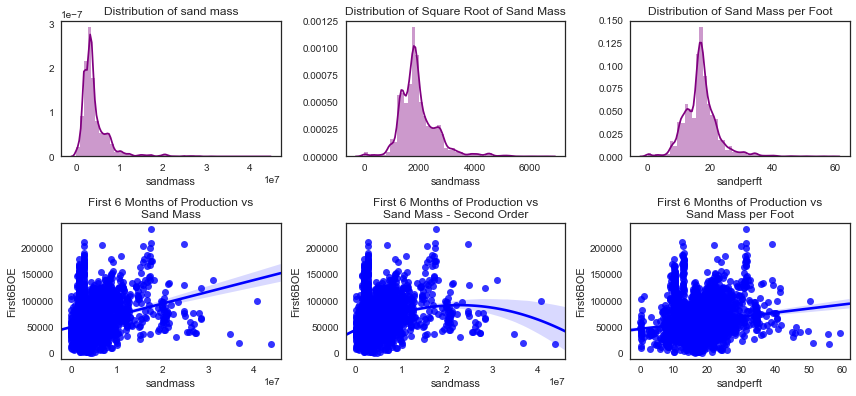

Linear R-squared: 0.07213160443350088
Linear p-value 1.2533232812442068e-75
Quadratic R-squared: 0.07252594769431134
Quadratic p-value 4.778476327681648e-76
Sandperft R-squared: 0.024689171915889284
Sandperft p-value 2.0689975329780616e-26


In [14]:
# Plotting distribution of sand mass
plt.figure(figsize=(12,8))
plt.subplot(331)
# Selecting relevant columns and eliminiating outliers
temp = cofracw[['sandmass', 'First6BOE', 'sandperft']].dropna(axis=0)
temp = temp[temp['sandmass'] < 0.5e8][temp['sandmass'] > 0]
sns.distplot(temp.sandmass, color='Purple')
plt.title('Distribution of sand mass')

plt.subplot(332)
sns.distplot(np.sqrt(temp.sandmass.dropna(axis=0)), color='Purple')
plt.title('Distribution of Square Root of Sand Mass')

plt.subplot(333)
sns.distplot(np.sqrt(temp.sandperft), color='Purple')
plt.title('Distribution of Sand Mass per Foot')

# Plotting scatter plot of sand mass by production
plt.subplot(334)
sns.regplot(x=temp.sandmass, y=temp.First6BOE, color='Blue', order=1)
plt.title('First 6 Months of Production vs\nSand Mass')

plt.subplot(335)
sns.regplot(x=temp.sandmass, y=temp.First6BOE, color='Blue', order=2)
plt.title('First 6 Months of Production vs\nSand Mass - Second Order')

plt.subplot(336)
sns.regplot(x=np.sqrt(temp.sandperft), y=temp.First6BOE, color='Blue', order=1)
plt.title('First 6 Months of Production vs\nSand Mass per Foot')

plt.tight_layout()
plt.show()

# Calculating the R-squared values for each variable
m, b, r, p, se = linregress(temp.sandmass, temp.First6BOE)
print('Linear R-squared:', r**2)
print('Linear p-value', p)

m, b, r, p, se = linregress(np.sqrt(temp.sandmass), temp.First6BOE)
print('Quadratic R-squared:', r**2)
print('Quadratic p-value', p)

m, b, r, p, se = linregress(temp.sandperft, temp.First6BOE)
print('Sandperft R-squared:', r**2)
print('Sandperft p-value', p)

The sand per linear foot transformation definitely looks most normal, but the R-squared for the regression is fairly low, so I will definitely keep the sand per linear foot and square root of sand mass as a feature. I will also drop the extreme outlier of sand mass and the zero-values of sand.

In [15]:
# Creating square root of sand mass feature
cofracw['sqrtsandmass'] = np.sqrt(cofracw['sandmass'])
# Eliminating extreme sand mass outlier
cofracw = cofracw[cofracw.sandmass < 0.5e8][cofracw.sandmass > 0]

### Independence between Variables
Next, I want to check out the independence between the various variables to determine the overlap of information.

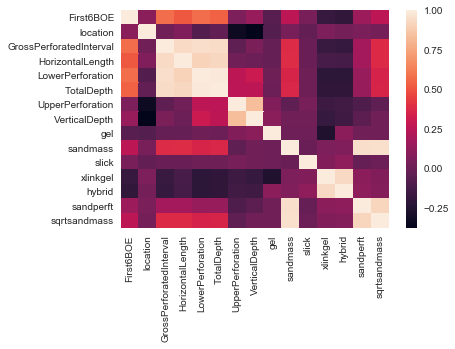

In [16]:
corrmat = cofracw.corr()
sns.heatmap(corrmat)
plt.show()

Because the gross perforated interval, horizontal length, lower perforation and total depth are all highly correlated with one another, I will need to decide which variables to keep and/or engineer and which to remove.  

Current rationale:
- Total depth represents the horizontal length plus the vertical depth, both of which are important decision points for well operators.  For this reason, I will __drop total depth__.
- Upper and Lower Perforations, along with the gross perforated interval all, in theory, should be related to one another. I want to see if I can __engineer the non-perforated horizontal length ( $HorizontalLength - GrossPerforatedInterval$ )__ to get more information from those, without having to drop too much information.  I will also __drop upper and lower perforations__.
- Knowing the data, I will also have to __impute some of the gross perforated intervals__, so I will see how those compare to horizontal length to possibly impute from that.

In [17]:
# Dropping total depth, lower and upper perforations
cofracw = cofracw.drop(['TotalDepth', 'LowerPerforation', 'UpperPerforation'], axis=1)
cofracw = cofracw.dropna(subset=['VerticalDepth'], axis=0)

### Horizontal Length and Grosss Perforated Interval
Now because gross perforated interval and horizontal length were highly correlated, I want to check the relationship between the two to see if these are linearly related so I can potentially use that relationship to impute the missing gross perforated interval values. 

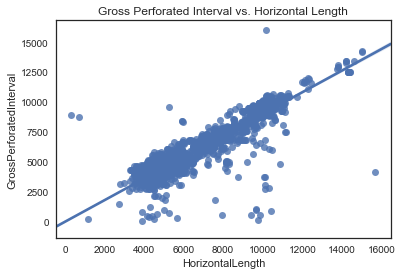

Slope: 0.9628966049370298
Intercept: 793.1997205677235
R-squared: 0.8680938817354695


In [18]:
# Graphing Gross perforated interval versus horizontal length
temp = cofrac[['GrossPerforatedInterval', 'HorizontalLength']].dropna()
sns.regplot(y=temp.GrossPerforatedInterval, x=temp.HorizontalLength)
plt.title('Gross Perforated Interval vs. Horizontal Length')
plt.show()

m, b, r, p, se = linregress(temp.GrossPerforatedInterval, temp.HorizontalLength)
print('Slope: {}\nIntercept: {}\nR-squared: {}'.format(m,b, r**2))

Based on this analysis, the gross perforated interval is 0.97 times as large as the horizontal length.  This is a pretty tight correlation because the R-squared value is 0.94 and the p-value is 0.0.  For this reason, I will impute missing gross perforated intervals by multiplying 0.97 times the horizontal length. I will also drop all wells with a horizontal length of less than 2000 ft, which is an unrealistic and incorrect data point for a well.

In [19]:
todrop = cofracw[cofracw['HorizontalLength']<2000].index
cofracw = cofracw.drop(todrop, axis=0)

Great, now I want to impute gross perforated intervals for missing data before engineering another variable using those values.  The equation I will use comes from the linear relationship between gross perforated interval and horizontal length, which is: $ GPI = HZlength * 0.9743 + 711.3 $

In [20]:
# Calculating predicted values for Gross Perforated Interval
cofracw['GPIpred'] = cofracw.HorizontalLength*0.9742595569413872 + 711.3033745388957

# Filling all NAs with 0 for imputing
cofracw2 = cofracw.fillna(0)

# Imputing
for idx in cofracw2.index:
    if cofracw2.GrossPerforatedInterval[idx] > 0:
        pass
    else:
        cofracw2.GrossPerforatedInterval[idx] = cofracw2['GPIpred'][idx]

#### Feature Engineering - Non-perforated Horizontal Feet
Knowing that there is a relationship between horizontal feet and gross perforation interval, I want to capture the information that is in the difference between the two values.  To capture this, I will calculate the non-perforated feet. 

In [21]:
# Calculating non-perforated horizontal feet
nonperfhzft = cofracw2.HorizontalLength - cofracw2.GrossPerforatedInterval

# Comparison testing between distributions of non-perforated feet and production 
spearmanr(nonperfhzft, cofracw2['First6BOE'])

SpearmanrResult(correlation=0.06176559658553038, pvalue=3.367251368764284e-05)

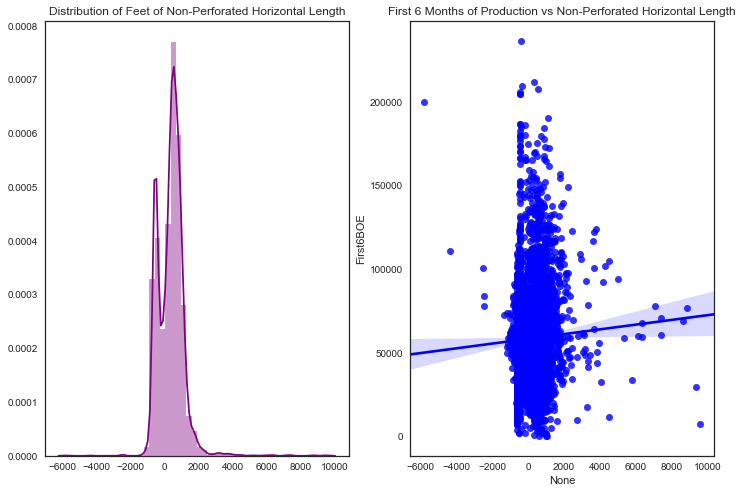

count    4502.000000
mean      376.948900
std       776.398588
min     -5800.430000
25%      -165.502500
50%       435.985000
75%       780.047500
max      9589.510000
dtype: float64

In [22]:
# Graphing Distrubtion of non-perforated feet and its relationship to production
plt.figure(figsize=(12,8))
plt.subplot(121) 
sns.distplot(nonperfhzft, color='Purple')
plt.title('Distribution of Feet of Non-Perforated Horizontal Length')

plt.subplot(122)
sns.regplot(x=nonperfhzft, y=cofracw2.First6BOE, color='Blue', order=1)
plt.title('First 6 Months of Production vs Non-Perforated Horizontal Length')
plt.show()
nonperfhzft.describe()

This looks like the non-perforated feet is a bimodal distribution, with the split at zero.  Gross perforated feet over horizontal length means that the operator fraced the vertical section of the well in addition to the horizontal section, whereas a positive value of non-perforated horizontal feet means that the operator only fraced a portion of the horizontal length.  Because of this bimodal distribution, I will try some transformations to create a more normal distribution, but I also might try to binarize this variable into only-horizontal frac versus horizontal and vertical fracing.

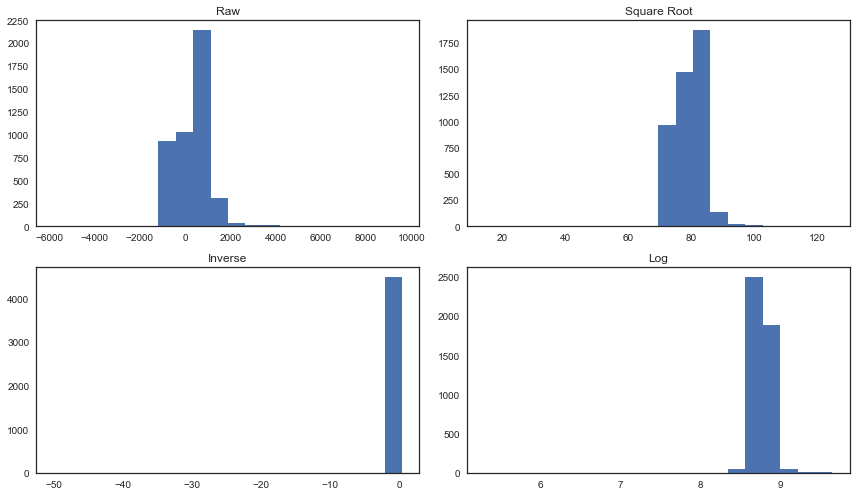

In [23]:
# Transformations for non-normality
plt.figure(figsize=[12,7])
plt.subplot(221)
plt.hist(nonperfhzft, bins=20)
plt.title('Raw')

plt.subplot(222)
plt.hist(np.sqrt(nonperfhzft+6000), bins=20)
plt.title('Square Root')

plt.subplot(223)
plt.hist(1/nonperfhzft, bins=20)
plt.title('Inverse')

plt.subplot(224)
plt.hist(np.log(nonperfhzft+6000), bins=20)
plt.title('Log')

plt.tight_layout()
plt.show()

The square root transformation looks most normal, but I had to add a value of 6000 to make all of the values positive to take the square root. 

In [24]:
cofracw2['nphf_sqrt'] = np.sqrt(nonperfhzft+6000)

#### Feature Engineering - Binned Horizontal Length
As mentioned earlier, I will bin the horizontal feet to eliminate the trimodal distribution.

In [25]:
# Creating bins for the three general horizontal legnths
bins = [0,6500,8500,250000]
cofracw2['hzlen_bin'] = pd.cut(cofracw2['HorizontalLength'], bins,
                              labels = ['<1', '1-2', '>2'])

Now, I want to check to see how the bins are related to production in the first six months after fracing.

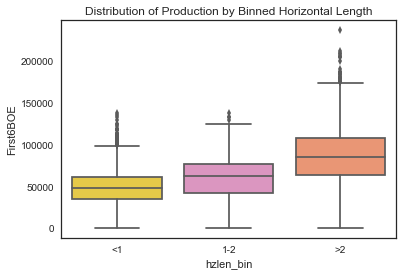

In [26]:
# Plotting distribtion of binary feature
sns.boxplot(y='First6BOE', x='hzlen_bin', data=cofracw2, palette='Set2_r')
plt.title('Distribution of Production by Binned Horizontal Length')
plt.show()

Wow, this definitely looks like the longer the horizontal length, the greater the production.  I will check this difference through the Kruskal test for the three distributions. If the p-value of this test is significant at an alpha of 0.05, then there is a difference in the distributions.

In [27]:
print('Binned Kruskal: {}'.format(kruskal(cofracw2[cofracw2.hzlen_bin=='<1']['First6BOE'], 
                                            cofracw2[cofracw2.hzlen_bin=='1-2']['First6BOE'],
                                         cofracw2[cofracw2.hzlen_bin=='>2']['First6BOE'])))

Binned Kruskal: KruskalResult(statistic=956.9809786019097, pvalue=1.563942758152597e-208)


Based on the p-value from the Kruskal test, there is a significant difference between the production of the bins.  This does not give us information about which are different, so I will calculate the Mann Whitney U test for each pair.

In [28]:
print('<1 vs 1-2', mannwhitneyu(cofracw2[cofracw2['hzlen_bin']=='<1']['First6BOE'], 
                             cofracw2[cofracw2['hzlen_bin']=='1-2']['First6BOE']))
print('<1 vs >2', mannwhitneyu(cofracw2[cofracw2['hzlen_bin']=='<1']['First6BOE'], 
                             cofracw2[cofracw2['hzlen_bin']=='>2']['First6BOE']))
print('1-2 vs >2', mannwhitneyu(cofracw2[cofracw2['hzlen_bin']=='1-2']['First6BOE'], 
                             cofracw2[cofracw2['hzlen_bin']=='>2']['First6BOE']))

<1 vs 1-2 MannwhitneyuResult(statistic=746405.0, pvalue=5.389325106596935e-35)
<1 vs >2 MannwhitneyuResult(statistic=437760.5, pvalue=3.6946877340667905e-197)
1-2 vs >2 MannwhitneyuResult(statistic=183059.5, pvalue=2.8349558877896165e-55)


Based on the Mann Whitney U Test, all of the bins of horizontal length have significant differences in production.  I will definitely keep this as a feature in our modeling.

### Gathering Features for Modeling
Based on the above analysis, the following are features that I will use to predict the production from the first six months of the well:
- Types of Fracing: Gel, Slickwater and Cross-linked Gel
- Drilling Characteristics: Target Formation, Vertical Depth, Horizontal Length (binned), and Non-perforated length (square root)
- Frac Characteristic: Sand mass (square root)


In [29]:
cofeats = cofracw2.drop(['First6BOE', 'sandmass','GrossPerforatedInterval',
                        'HorizontalLength', 'sqrtsandmass', 'GPIpred'], axis=1)
cofeats = pd.get_dummies(cofeats)

target = cofracw2.First6BOE

X_train, X_test, y_train, y_test = train_test_split(cofeats, target, test_size=0.25, random_state=42)

## Modeling
This section will feature the best models for the Colorado data.  Further models that were tried can be found [here](https://github.com/ephs08kmp/Frac_Production/blob/master/Frac_Production_Modeling_CO.ipynb).

First I will write two functions to streamline training and testing the models.  The training function will fit the model and then cross validate the scores and return the scores.  The test function will cross validate and return the scores.

In [30]:
def train_model(model, X, Y, cv):
    """This function will fit the specified model and run cross validation on the training
    and set.  Returns mean and variance in cross validation scores.
    Model: specified model must be instantiated
    X, Y: training sets to use to fit model
    cv: number of folds in cross validation"""
    model.fit(X, Y)
    scores = cross_val_score(model, X, Y, cv=cv)
    return '{:0.4f} (+/- {:0.4f})'.format(scores.mean(), scores.std()*2)

def test_model(model, X, Y, cv):
    """This function will run cross validation on the test set.  
    Returns mean and variance in cross validation scores.
    Model: specified model must be instantiated
    X, Y: test sets to use to fit model
    cv: number of folds in cross validation"""
    scores = cross_val_score(model, X, Y, cv=cv)
    return '{:0.4f} (+/- {:0.4f})'.format(scores.mean(), scores.std()*2)


### Random Forest Regression
Linear regression performed poorly, with an R-squared score of only 0.32 (+/- 0.07), so then next model I chose was random forest regression to hopefully get around the non-linearity of the target and the non-normal distributions of a lot of the features, even after transformations.

In [31]:
# Instantiate the model
rfr = RandomForestRegressor(random_state=42)
# Fit the model and generate training scores
rfr_train = train_model(rfr, X_train, y_train, 5)
# Generate test scores
rfr_test = test_model(rfr, X_test, y_test, 5)
print('Training Scores: {}'.format(rfr_train))
print('Test Scores: {}'.format(rfr_test))

Training Scores: 0.6034 (+/- 0.0945)
Test Scores: 0.4692 (+/- 0.0981)


Because this score isn't great, I will use a GridSearchCV to optimize the parameters of the model.  I will optimize the number of estimators, the max features used, the minimum samples split, and the max depth of the tree all for the engineered features.

In [32]:
# Identifying potential parameters
param_grid = { 
            "n_estimators"      : [200, 400, 600],
            "max_features"      : ["sqrt"],
            "min_samples_split" : [2,4,6,8],
            "max_depth": [4,6,8,10]
            }
# Instantiating grid search
grid = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5)
# Fitting model
grid.fit(X_train, y_train)
# Identifying best score and best parameters from the Grid Search
print(grid.best_score_)
best_params = grid.best_params_
print(best_params)

0.6145409731023709
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 600}


Now that GridSearchCV has identified the optimal parameters from the set, I will use those parameters to fit a model and see what the training and test set scores look like.

In [33]:
# Instantiate the model
rfr_grid = RandomForestRegressor(**best_params)
# Fit the model and generate training scores
rfr_grid_train = train_model(rfr_grid, X_train, y_train, 5)
# Generate test scores
rfr_grid_test = test_model(rfr_grid, X_test, y_test, 5)
print('Training Scores: {}'.format(rfr_grid_train))
print('Test Scores: {}'.format(rfr_grid_test))

Training Scores: 0.6152 (+/- 0.0582)
Test Scores: 0.5304 (+/- 0.1289)


Even better! The test score mean increased, but there is still a sizable variance in the scores between the folds. 

Let's check out the different feature importances to see what features are influencing the model most.

,importance
VerticalDepth,0.207652
hzlen_bin_>2,0.181000
sandperft,0.168266
hzlen_bin_<1,0.123199
nphf_sqrt,0.115447
location,0.104335
hybrid,0.036833
hzlen_bin_1-2,0.030191
xlinkgel,0.025914
gel,0.004995


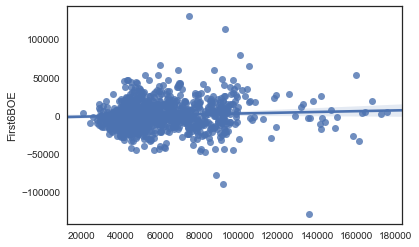

In [34]:
feature_importances3 = pd.DataFrame(rfr_grid.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
display(feature_importances3)

# Plot Residuals vs Predicted values
y_pred = rfr_grid.predict(X_test)
residuals = y_test - y_pred
sns.regplot(x=y_pred, y=residuals)
plt.show()

There was about a 50K spread amongst the majority of the predicted values, however there were three extreme outliers with residuals of greater than 100K.

### Random Forest Quantile Regressor
Because my features and especially my target are non-normally distributed even after tranformations, I will try a random forest quantile regressor.  In a quantile decision tree, the trees predict the percentile and quantile for the data point.  This means that each sample is searched for a leaf that it falls into and a weight is given to that data point based on the fraction of samples in that same leaf, and the weights are summed and averaged.  The output is then the percentile of the data set.

In [35]:
# Instantiating and fitting model
rfqr = RandomForestQuantileRegressor(random_state=42)
rfqr_train = train_model(rfqr, X_train, y_train, 5)
rfqr_test = test_model(rfqr, X_test, y_test, 5)
# Printing train and test scores
print('Training Scores: {}'.format(rfqr_train))
print('Test Scores: {}'.format(rfqr_test))

Training Scores: 0.6034 (+/- 0.0945)
Test Scores: 0.4692 (+/- 0.0981)


I will use a GridSearchCV to optimize the parameters of the model.  I will optimize the number of estimators, the max features used, the minimum samples split, and the max depth of the tree all for the engineered features.

In [36]:
# Identifying potential parameters
param_grid = { 
            "n_estimators"      : [200, 400, 600],
            "max_features"      : ["sqrt"],
            "min_samples_split" : [2,4,6,8],
            "max_depth": [4,6,8,10]
            }
# Instantiating grid search
grid = GridSearchCV(estimator=rfqr, param_grid=param_grid, cv=5)
# Fitting model
grid.fit(X_train, y_train)
# Identifying best score and best parameters from the Grid Search
print(grid.best_score_)
best_params = grid.best_params_
print(best_params)

0.6145409731023709
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 600}


Now that GridSearchCV has identified the optimal parameters from the set, I will use those parameters to fit a model and see what the training and test set scores look like.

In [37]:
# Instantiate the model
rfqr_grid = RandomForestRegressor(**best_params)
# Fit the model and generate training scores
rfqr_grid_train = train_model(rfqr_grid, X_train, y_train, 5)
# Generate test scores
rfqr_grid_test = test_model(rfqr_grid, X_test, y_test, 5)
print('Training Scores: {}'.format(rfqr_grid_train))
print('Test Scores: {}'.format(rfqr_grid_test))

Training Scores: 0.6146 (+/- 0.0595)
Test Scores: 0.5336 (+/- 0.1256)


This looks better! I'm still surprised at how low the overall R-squared score is, but there is a large amount of variablility in this data, not only in the production, but also each of the individual well characteristics, including frac fluid systems. 

,importance
VerticalDepth,0.205630
hzlen_bin_>2,0.185994
sandperft,0.170217
hzlen_bin_<1,0.118803
nphf_sqrt,0.114678
location,0.106578
hybrid,0.035427
hzlen_bin_1-2,0.030536
xlinkgel,0.025182
gel,0.004760


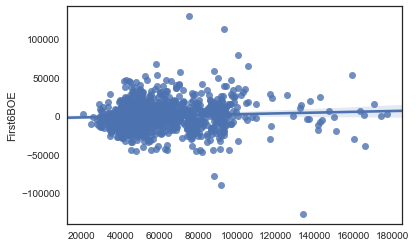

In [38]:
feature_importances5 = pd.DataFrame(rfqr_grid.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
display(feature_importances5)

# Plot Residuals vs Predicted values
y_pred = rfqr_grid.predict(X_test)
residuals = y_test - y_pred
sns.regplot(x=y_pred, y=residuals)
plt.show()

For now, I will finish analyzing the Colorado data by inspecting the partial dependency plots because the overall goal is to better understand how each feature contributes to the production of the well.  

## Partial Dependency Plots
Partial dependency plots enable a view inside of the black boxes that are random forests.  They show how the outcome depends on each individual feature in the model.  This way we can get "coefficients" for each feature and see anomalies in the patterns.  I will also use the horizontal length feature to determine the variablity in that feature.

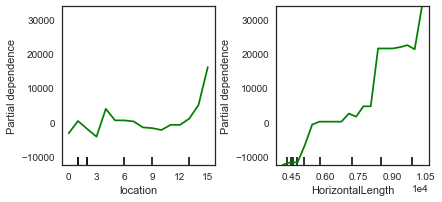

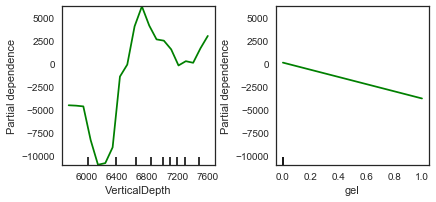

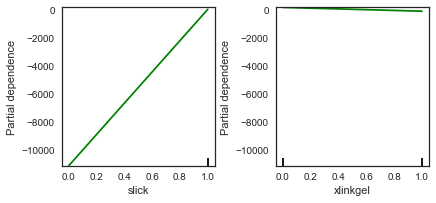

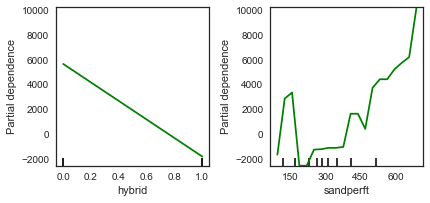

In [39]:
cofeats2 = cofracw2.drop(['First6BOE', 'sandmass','GrossPerforatedInterval',
                        'hzlen_bin', 'sqrtsandmass', 'GPIpred'], axis=1)

target = cofracw2.First6BOE


gbr = GradientBoostingRegressor()
gbr.fit(cofeats2, target)

feats = [[0,1],
         [2,3],
        [4,5], 
         [6,7]]

for feat_set in feats:
    gbr_plots = plot_partial_dependence(gbr,
                                features=feat_set, # Column numbers to plot
                                X=cofeats2, # Raw predictors data
                                n_cols=2,
                                feature_names=cofeats2.columns, # Labels on graph
                                grid_resolution=20) # Number of values to plot on x-axis

## Frac Well Summary
For this project, I wanted to build models that would help well operators in Colorado both understand the data-based best practices for frac characteristics and fluid systems, and be able to predict the production of the well within the first six months. The information I used and engineered to perform this analysis were the frac fluid systems, namely slickwater, linear gel, crosslinked gel, or a hybrid approach; the drilling conditions, including the horizontal length and the vertical depth of a well; and finally the frac conditions, including the amount of sand used per foot drilled, and the length of un-perforated casing. Through partial dependency plots and feature importances, here are the most important features and how they impact production:
- Horizontal Length
    - Lengths of less than 1 mile had lowest odds of production, between 1 and 2 miles there is very little change in the odds of production, and at greater than two miles of horizontal length there are the greatest odds of higher production levels.
- Vertical Depth
    - The odds of higher production based on vertical depth increases between 6250 ft and peaks at 6600 ft.  After 6600 ft, the odds of higher production decreases.
- Sand per Foot
    - Based on pounds of sand per foot of casing, there is a spike in the odds of higher production around 150 pounds per foot, which then drops between  200 and 350 pounds of sand per foot, and then increases steadily as the amount of sand increases.
    
This means that while there is a cost to increasing the each of these attributes of the well, well operators would do well to aim for around 2 miles of horizontal, 6600 ft vertical, and around 600+ pounds of sand per foot of casing.  As for the frac fluid systems, the following are the analysis of their impact on frac production according to the overall model:
- Slickwater
    - Using a slickwater approach had great impact on the odds of higher production as compared to not using slickwater. 
- Linear Gel
    - The odds of higher production are higher if a well operator does not use linear gel.
- Cross-linked Gel
    - Using cross-linked gel has very little impact on the odds of production.
- Hybrid Fluid System
    - The odds of production are higher if a hybrid approach is not used.
    
This is not very informative, most likely because the overall model looked at all attributes of the well, not just the frac fluid system.  I will now model only the frac fluid systems to interpret the odds of increased production.

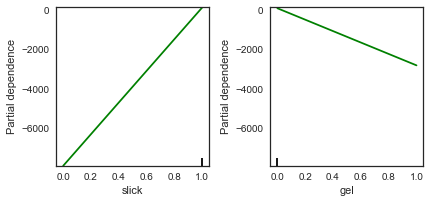

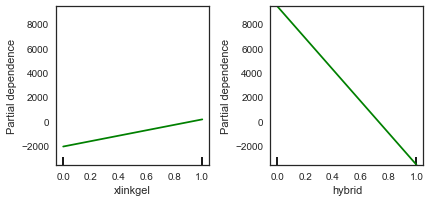

In [40]:
allflsys = cofeats[['slick', 'gel', 'xlinkgel', 'hybrid']]

gbr_m = GradientBoostingRegressor(random_state=42)
gbr_m.fit(allflsys, target)

feats = [[0,1],
         [2,3]]

for feat_set in feats:
    gbr_plots = plot_partial_dependence(gbr_m,
                                features=feat_set, # Column numbers to plot
                                X=allflsys, # Raw predictors data
                                n_cols=2,
                                feature_names=allflsys.columns, # Labels on graph
                                grid_resolution=20) # Number of values to plot on x-axis

According to the model only looking at how frac fluid system affects production, the following are the analysis of their impact on well production:
- Slickwater
    - Using a slickwater approach increases the odds of higher production.
- Linear Gel
    - The odds of higher production are higher if a well operator does not use linear gel.
- Cross-linked Gel
    - Using a cross-linked gel causes a moderate increase in the odds of higher production.
- Hybrid Approach
    - The odds of production are higher if a hybrid approach is not used.
    
__Overall, a well operator would be best off if they used a slickwater fluid system or a cross-linked gel fluid system in fracing, but linear gels and hybrid fluid systems are not recommended.__  

In [41]:
# Printing models all together
print('R-squared Scores on the Test Set:\n')
print('Random Forest Regression \t\t{}'.format(rfr_grid_test))
print('\nRandom Forest Quantile Regression \t{}'.format(rfqr_grid_test))

R-squared Scores on the Test Set:

Random Forest Regression 		0.5304 (+/- 0.1289)

Random Forest Quantile Regression 	0.5336 (+/- 0.1256)


Overall, all three models were fairly close in their ability to predicte the first 6 months of production, however the best model was the Random Forest Quantile Regression model, with an R-squared value of 0.5328 +/- 0.13. The Random forest regression had an R-squared value of 0.5352 +/- 0.12, and the gradient boosting regression had the lowest R-squared value of 0.5040 +/- 0.10. The Gradient boosting regression, along with partial dependency plots, were able to  paint a picture of the importances of the different well and frac characteristics to determine what contributes to higher oil and gas production.

## Product Proof of Concept
Now I will take a couple wells and demonstrate that with different frac fluid systems, the model will predict different levels of production. I will take a couple of random wells.  I will use the drilling characteristics of the well and manually vary the frac fluid systems to determine which fluid system could have improved the production of this well.

In [42]:
poc_wells = [X_train[X_train.index==5001098410000], X_test[X_test.index==5123447110000]]

Now, using these wells, I will individually set each fluid system to true (1), including a hybrid of slickwater and linear gel, and a hybrid of slickwater and crosslinked gel. I will then predict the production of that well based on the fluid system type, and graph the predicted productions of each well.

,location,VerticalDepth,gel,slick,xlinkgel,hybrid,sandperft,nphf_sqrt,hzlen_bin_<1,hzlen_bin_1-2,hzlen_bin_>2
APINumber,,,,,,,,,,,
5001098410000,2,8045.0,1,0,0,0,247.216535,73.509025,1,0,0
5001098410000,2,8045.0,0,1,0,0,247.216535,73.509025,1,0,0
5001098410000,2,8045.0,0,0,1,0,247.216535,73.509025,1,0,0
5001098410000,2,8045.0,1,1,0,1,247.216535,73.509025,1,0,0
5001098410000,2,8045.0,0,1,1,1,247.216535,73.509025,1,0,0


,Fluid_System,Predicted_Production(BOE)
1,slick,51951
3,slick_gel_hybrid,50683
4,slick_xlinkgel_hybrid,40718
0,gel,39395
2,xlinkgel,38596


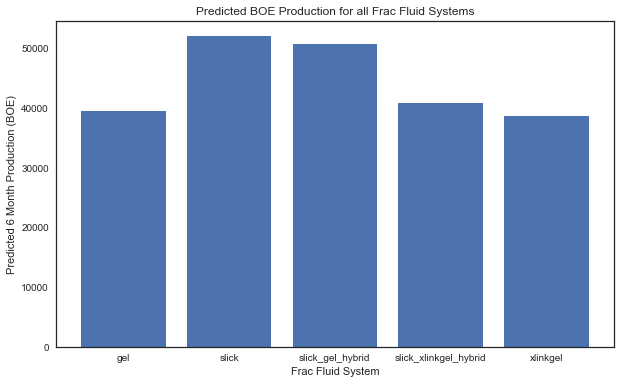

,location,VerticalDepth,gel,slick,xlinkgel,hybrid,sandperft,nphf_sqrt,hzlen_bin_<1,hzlen_bin_1-2,hzlen_bin_>2
APINumber,,,,,,,,,,,
5123447110000,0,7443.0,1,0,0,0,685.835782,74.562688,0,0,1
5123447110000,0,7443.0,0,1,0,0,685.835782,74.562688,0,0,1
5123447110000,0,7443.0,0,0,1,0,685.835782,74.562688,0,0,1
5123447110000,0,7443.0,1,1,0,1,685.835782,74.562688,0,0,1
5123447110000,0,7443.0,0,1,1,1,685.835782,74.562688,0,0,1


,Fluid_System,Predicted_Production(BOE)
1,slick,98773
0,gel,86501
2,xlinkgel,85995
4,slick_xlinkgel_hybrid,77810
3,slick_gel_hybrid,72537


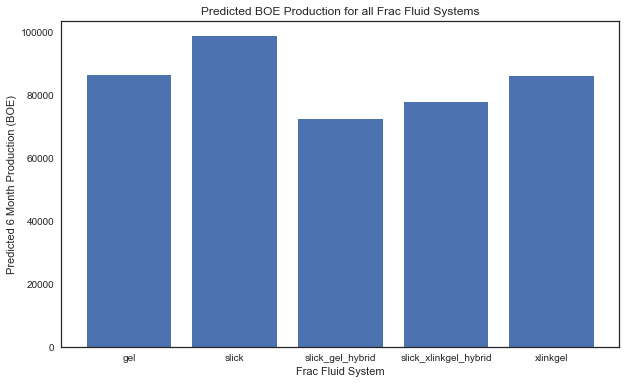

In [44]:
# Identifying all fluid systems
flsys = ['gel','slick','xlinkgel']

# Identifying the two hybrid types
hybrids = ['gel', 'xlinkgel']

for well in poc_wells:
    
    # Creating data frame for the proof of concept wells and a data frame to store the predicted production
    poc = pd.DataFrame()
    preds = pd.DataFrame(columns=['Fluid_System','Predicted_Production(BOE)'])

    for sys in flsys:
        # Re-setting all systems to 0
        well['slick'] = 0
        well['gel'] = 0
        well['xlinkgel'] = 0
        well['hybrid'] = 0
    
        well_ex = well
        # Setting each system to 1
        well_ex[sys] = 1
        # Appending the well to the data frame
        poc = poc.append(well_ex)
        # Predicting the production of that fluid system
        pred = rfr_grid.predict(well_ex)
        # Appending the predicted production and fluid system
        preds = preds.append({'Fluid_System':sys, 'Predicted_Production(BOE)':int(pred)}, ignore_index=True)

    for hybrid in hybrids:
        # Re-setting all gel systems to 0
        well['gel'] = 0
        well['xlinkgel'] = 0
        
        well_ex = well
        # Setting hybrid and slick to 1 (all hybrids are a hybrid of slickwater and something else)
        well_ex['hybrid'] = 1
        well_ex['slick'] = 1
        # Setting the second hybrid ingredient to 1 and appending to the data frame
        well_ex[hybrid] = 1
        poc = poc.append(well_ex)
        # Predicting the production of that system
        pred = rfr_grid.predict(well_ex)
        # Appending the predicted production and system
        preds = preds.append({'Fluid_System':'slick_'+ hybrid + '_hybrid', 'Predicted_Production(BOE)':int(pred)}, ignore_index=True)

    
    display(poc)
    # Sorting predicted values
    display(preds.sort_values('Predicted_Production(BOE)', ascending=False))

    plt.figure(figsize=(10,6))
    plt.bar(preds['Fluid_System'], height=preds['Predicted_Production(BOE)'])
    plt.xlabel('Frac Fluid System')
    plt.ylabel('Predicted 6 Month Production (BOE)')
    plt.title('Predicted BOE Production for all Frac Fluid Systems')
    plt.show()

With the first example well, while keeping all drilling characteristics the same, in using a slickwater system, the well operators could predict approximately an extra 100 BOE over using a slickwater-linear gel hybrid system, and over using a slickwater-cross-linked gel hybrid system, the well operator could predict 10,000 BOE of extra production. For this well, the worst predicted production comes with a gel fluid system, either linear or crosslinked. 

In the second example well, slickwater again has a predicted advantage over the other fluid systems, with an approximately 10,000 BOE increase in production over other systems. Interestingly enough, for this well, the linear gel and cross-linked gels performed approximately equally, and above the hybrid approaches. 

## Conclusion
For this project, I was tasked to build models to predict what conditions and fluid systems of hydraulic fracturing produces the most oil and gas outputs, measured in BOE. The information I used and engineered to perform these predictions came from mapping the ingredients to the different frac fluid systems, the horizontal length, vertical depth, and perforated intervals in those lenghts, and the mass of sand used per foot. Using these features, normalized for location, the best model to predict production in terms of R-squared value and the computation time was the Random Forest Regression model.  

### Model Trends
#### Drilling
The trends I observed in the model were that as the horizontal length increases, the odds of higher production increase, and the vertical depth is optimal around 6600 ft. 

#### Frac Conditions
In hydraulic fracturing of the well, the amount of sand per foot has better odds of high production around 150 pounds per foot and also above 350 pounds per foot.  Well operators would also benefit from using a slickwater approach above all other frac fluid systems.  Depending on the other characteristics of the well, using a cross-linked gel or a hybrid approach might also increae the predicted production of the well.  

A well operator would do well to assess the costs and benefits of the individual fluid systmes to determine their individual sweet spots for the location of the well. 

### Overall Model
Overall, the models that explained the most variance in the data were the random forest regression model and the random forest quantile regression model. These models had R-squared values of 0.533 +/- 0.12, which, considering the variance in each of the features of the model, this is low yet unsurprising.  The benefits of using the random forest model are that its computational cost is lower than that of the random forest quantile regression, and provides the feature importances of the features.  Using the partial dependency plots, we can see how the changes in each of these important features impacts the production of the well.  

### Product Proof of Concept
Once a well operator has finished drilling a well, they know the horizontal length, vertical depth, and location.  The operator should then select an amount of length to perforate, a mass of sand to use per linear foot, and then they are  able to use the random forest model to determine which frac fluid system to use by predicting the production for each type. These decisions can then be weighed on a cost basis to determine if the costs are worth the increase in production.